# Entrega 1 - Data Mining Project
## Integrantes
* Wenyi He
* Leonardo Olivares

## Dependencias:
* cartopy ```conda install -c conda-forge cartopy```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
from sklearn.preprocessing import MinMaxScaler
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import itertools
import matplotlib as mpl
import matplotlib.patches as mpatches

# Pre-Processing
Se combina los resultados de las encuestas del año 2017 y 2018

In [2]:
df2017 = pd.read_csv("2017/survey_results_public.csv")
df2018 = pd.read_csv("2018/survey_results_public.csv")

C:\Users\hewen\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
column_2017 = list(df2017.columns.values)
column_2018 = list(df2018.columns.values)

Renombrar las columnas para que sean consistentes

In [4]:
df2017.rename(columns={
    'EmploymentStatus': 'Employment',
    'MajorUndergrad': 'UndergradMajor',
    'DeveloperType': 'DevType',
    'YearsProgram': 'YearsCoding',
    'YearsCodedJobPast' : 'YearsCodingProf',
    'JobSatisfaction' : 'JobSatisfaction',
    'CareerSatisfaction' : 'CareerSatisfaction',
    'JobSeekingStatus' : 'JobSearchStatus',
    'LastNewJob' : 'LastNewJob',
    'EducationTypes' : 'EducationTypes',
    'SelfTaughtTypes' : 'SelfTaughtTypes',
    'TimeAfterBootcamp' : 'TimeAfterBootcamp',
    'KinshipDevelopers' : 'AgreeDisagree1',
    'CompetePeers' : 'AgreeDisagree2',
    'HaveWorkedLanguage' : 'LanguageWorkedWith',
    'WantWorkLanguage' : 'LanguageDesireNextYear',
    'HaveWorkedDatabase' : 'DatabaseWorkedWith',
    'WantWorkDatabase' : 'DatabaseDesireNextYear',
    'HaveWorkedPlatform' : 'PlatformWorkedWith',
    'WantWorkPlatform' : 'PlatformDesireNextYear',
    'HaveWorkedFramework' : 'FrameworkWorkedWith',
    'WantWorkFramework' : 'FrameworkDesireNextYear',
    'IDE' : 'IDE',
    'Methodology' : 'Methodology',
    'VersionControl' : 'VersionControl',
    'CheckInCode' : 'CheckInCode',
    'Gender' : 'Gender',
    'HighestEducationParents' : 'EducationParents',
    'Race' : 'RaceEthnicity',
}, inplace=True)

In [5]:
df2017["SurveyYear"] = 2017
df2017["Hobby"] = False
df2017["OpenSource"] = False
df2018["SurveyYear"] = 2018

Separar las respuestas

In [6]:
for counter, option in enumerate(df2017["ProgramHobby"]):
    if option == 'Yes, both':
        df2017.set_value(counter, "Hobby", True)
        df2017.set_value(counter, "OpenSource", True)
    elif option == "Yes, I program as a hobby":
        df2017.set_value(counter, "Hobby", True)
    elif option == "Yes, I contribute to open source projects":
        df2017.set_value(counter, "OpenSource", True)
set_2017_2018 = [df2017, df2018]
df = pd.concat(set_2017_2018,  join="inner")
df = df.reset_index()

In [7]:
df = df.drop("Respondent", 1)
df.shape

(150247, 38)

In [8]:
# Set Hobby values to True or False
mask = df.Hobby == "Yes"
column_name = 'Hobby'
df.loc[mask, column_name] = True

mask = df.Hobby == "No"
column_name = 'Hobby'
df.loc[mask, column_name] = False

In [9]:
# Set OpenSource values to True or False
mask = df.OpenSource == "Yes"
column_name = 'OpenSource'
df.loc[mask, column_name] = True

mask = df.OpenSource == "No"
column_name = 'OpenSource'
df.loc[mask, column_name] = False

Puesto que las preguntas que son de selección múltiple, traen las respuestas juntas, se separa cada opción en una columna nueva

In [10]:
df_pre_separated = df.copy()#DevType Columns
a = df["DevType"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_").replace("-", "_"))
    except AttributeError:
        continue

for i in lista_attr:
    df[i]=False

for c, i in enumerate(a):
    try:
        if isinstance(i, str):
            types = i.split(";")
            for l in types: 
                df.set_value(c, l.strip().replace(" ", "_").replace("-", "_"), True)
    except AttributeError:
        continue
        
#Remove DevType

df = df.drop("DevType", 1)

In [11]:
#Standardize YearsCoding values
changes = {
    'Less than a year': '0-2 years',
    '1 to 2 years': '0-2 years',
    '2 to 3 years': '0-2 years',
    '3 to 4 years': '3-5 years',
    '4 to 5 years': '3-5 years',
    '5 to 6 years': '3-5 years',
    '6 to 7 years': '6-8 years',
    '7 to 8 years': '6-8 years',
    '8 to 9 years': '6-8 years',
    '9 to 10 years': '9-11 years',
    '10 to 11 years': '9-11 years',
    '11 to 12 years': '9-11 years',
    '12 to 13 years': '12-14 years',
    '13 to 14 years': '12-14 years',
    '14 to 15 years': '12-14 years',
    '15 to 16 years': '15-17 years',
    '16 to 17 years': '15-17 years',
    '17 to 18 years': '15-17 years',
    '18 to 19 years': '18-20 years',
    '19 to 20 years': '18-20 years',
    '21-23 years': '20 or more years',
    '24-26 years': '20 or more years',
    '27-29 years': '20 or more years',
    '30 or more years': '20 or more years',
    True: np.nan
}


for year_range in changes :
    mask = df.YearsCoding == year_range
    column_name = 'YearsCoding'
    df.loc[mask, column_name] = changes[year_range]

In [12]:
#Standardize YearsCodingProf values
changes = {
    'Less than a year': '0-2 years',
    '1 to 2 years': '0-2 years',
    '2 to 3 years': '0-2 years',
    '3 to 4 years': '3-5 years',
    '4 to 5 years': '3-5 years',
    '5 to 6 years': '3-5 years',
    '6 to 7 years': '6-8 years',
    '7 to 8 years': '6-8 years',
    '8 to 9 years': '6-8 years',
    '9 to 10 years': '9-11 years',
    '10 to 11 years': '9-11 years',
    '11 to 12 years': '9-11 years',
    '12 to 13 years': '12-14 years',
    '13 to 14 years': '12-14 years',
    '14 to 15 years': '12-14 years',
    '15 to 16 years': '15-17 years',
    '16 to 17 years': '15-17 years',
    '17 to 18 years': '15-17 years',
    '18 to 19 years': '18-20 years',
    '19 to 20 years': '18-20 years',
    '21-23 years': '20 or more years',
    '24-26 years': '20 or more years',
    '27-29 years': '20 or more years',
    '30 or more years': '20 or more years',
    True: np.nan
}


for year_range in changes :
    mask = df.YearsCodingProf == year_range
    column_name = 'YearsCodingProf'
    df.loc[mask, column_name] = changes[year_range]

In [13]:
#Standardize JobSatisfaction and CareerSatisfaction values
changes = {
    0.0: 'Extremely dissatisfied',
    1.0: 'Moderately dissatisfied',
    2.0: 'Moderately dissatisfied',
    3.0: 'Slightly dissatisfied',
    4.0: 'Slightly dissatisfied',
    5.0: 'Neither satisfied nor dissatisfied',
    6.0: 'Slightly satisfied',
    7.0: 'Slightly satisfied',
    8.0: 'Moderately satisfied',
    9.0: 'Moderately satisfied',
    10.0: 'Extremely satisfied',
    True: np.nan
}


for satis in changes :
    mask = df.JobSatisfaction == satis
    column_name = 'JobSatisfaction'
    df.loc[mask, column_name] = changes[satis]
    
for satis in changes:
    mask = df.CareerSatisfaction == satis
    column_name = 'CareerSatisfaction'
    df.loc[mask, column_name] = changes[satis]

In [14]:
#Standardize JobSearchStatus values
changes = {
    "I'm not actively looking, but I am open to new opportunities": 'I’m not actively looking, but I am open to new opportunities',
    True: np.nan
}


for status in changes :
    mask = df.JobSearchStatus == status
    column_name = 'JobSearchStatus'
    df.loc[mask, column_name] = changes[status]

In [15]:
#Standardize LastNewJob values
changes = {
    "I've never had a job": 'Not applicable/ never',
    True: np.nan
}


for status in changes :
    mask = df.LastNewJob == status
    column_name = 'LastNewJob'
    df.loc[mask, column_name] = changes[status]

In [16]:
# Set Currency values
mask = df.Currency == True
column_name = 'Currency'
df.loc[mask, column_name] = np.nan

mask = df.Currency == 'Indian rupees (?)'
column_name = 'Currency'
df.loc[mask, column_name] = 'Indian rupees (₹)'

mask = df.Currency == 'Russian rubles (?)'
column_name = 'Currency'
df.loc[mask, column_name] = 'Russian rubles (₽)'


In [17]:
#SaLARIO, 
df = df.drop("Salary", 1)


In [18]:
#EducationTypes Valores muy distintos
df = df.drop("EducationTypes", 1)

In [19]:
#SelfTaughtTypes Valores muy distintos
df = df.drop('SelfTaughtTypes', 1)


In [20]:
# Set TimeAfterBootcamp values
mask = df.TimeAfterBootcamp == "I haven't gotten a job as a developer yet"
column_name = 'TimeAfterBootcamp'
df.loc[mask, column_name] = 'I haven’t gotten a developer job'

mask = df.TimeAfterBootcamp == 'I already had a full-time job as a developer when I began the program'
column_name = 'TimeAfterBootcamp'
df.loc[mask, column_name] = 'I already had a job as a developer when I started the program'

mask = df.TimeAfterBootcamp == 'Immediately upon graduating'
column_name = 'TimeAfterBootcamp'
df.loc[mask, column_name] = 'Immediately after graduating'

In [21]:
#AgreeDisagree 1 y 2
mask = df.AgreeDisagree1 == True
column_name = 'AgreeDisagree1'
df.loc[mask, column_name] = np.nan

mask = df.AgreeDisagree2 == True
column_name = 'AgreeDisagree2'
df.loc[mask, column_name] = np.nan

In [22]:
#LanguageWorkedWith Columns
a = df["LanguageWorkedWith"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Worked")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Worked", True)
    except AttributeError:
        continue
        
#Remove LanguageWorkedWith

df = df.drop("LanguageWorkedWith", 1)

In [23]:
#LanguageDesire Columns
a = df["LanguageDesireNextYear"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Desire")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Desire", True)
    except AttributeError:
        continue
        
#Remove LanguageWorkedWith

df = df.drop("LanguageDesireNextYear", 1)

In [24]:
#DatabaseWorkedWith Columns
a = df["DatabaseWorkedWith"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_DB_Worked")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_DB_Worked", True)
    except AttributeError:
        continue
        
#Remove LanguageWorkedWith

df = df.drop("DatabaseWorkedWith", 1)

In [25]:
#DatabaseDesireNextYear Columns
a = df["DatabaseDesireNextYear"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_DB_Desire")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_DB_Desire", True)
    except AttributeError:
        continue
        
#Remove LanguageWorkedWith

df = df.drop("DatabaseDesireNextYear", 1)

In [26]:
#PlatformWorkedWith Columns
a = df["PlatformWorkedWith"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Plat_Worked")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Plat_Worked", True)
    except AttributeError:
        continue
        
#Remove PlatformWorkedWith

df = df.drop("PlatformWorkedWith", 1)

In [27]:
#PlatformWorkedWith Columns
a = df["PlatformDesireNextYear"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Plat_Desired")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Plat_Desired", True)
    except AttributeError:
        continue
        
#Remove PlatformDesireNextYear

df = df.drop("PlatformDesireNextYear", 1)

In [28]:
#IDE Columns
a = df["IDE"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_IDE")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_IDE", True)
    except AttributeError:
        continue
        
#Remove IDE

df = df.drop("IDE", 1)

In [29]:
#FrameworkWorkedWith Columns
a = df["FrameworkWorkedWith"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Frame_Worked")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Frame_Worked", True)
    except AttributeError:
        continue
        
#Remove FrameworkWorkedWith

df = df.drop("FrameworkWorkedWith", 1)

In [30]:
#FrameworkDesireNextYear Columns
a = df["FrameworkDesireNextYear"]

lista_attr = set()
for i in a:

    try:
        k = i.split(";")
        for j in k:
            lista_attr.add(j.strip().replace(" ", "_")+"_Frame_Desire")
    except AttributeError:
        continue
        
for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        types = i.split(";")
        for l in types: 
            df.set_value(c, l.strip().replace(" ", "_")+"_Frame_Desire", True)
    except AttributeError:
        continue
        
#Remove FrameworkDesireNextYear

df = df.drop("FrameworkDesireNextYear", 1)

In [31]:
#Methodology Columns
a = df["Methodology"]

lista_attr = set()
for i in a:

    try:
        if isinstance(i, str):
            k = i.split(";")
            for j in k:
                lista_attr.add(j.strip().replace(" ", "_").replace("-", "_")+"_Method")
    except AttributeError:
        continue

for i in lista_attr:
    df[i]=False
    
for c, i in enumerate(a):
    try:
        if isinstance(i, str):
            types = i.split(";")
            for l in types: 
                df.set_value(c, l.strip().replace(" ", "_").replace("-", "_")+"_Method", True)
    except AttributeError:
        continue
        
#Remove Methodology

df = df.drop("Methodology", 1)

In [32]:
#VersionControl Columns
a = df["VersionControl"]

lista_attr = set()
for i in a:

    try:
        if isinstance(i, str):
            k = i.split(";")
            for j in k:
                lista_attr.add(j.strip().replace(" ", "_").replace("-", "_")+"_VC")
    except AttributeError:
        continue

for i in lista_attr:
    df[i]=False


for c, i in enumerate(a):
    try:
        if isinstance(i, str):
            types = i.split(";")
            for l in types: 
                df.set_value(c, l.strip().replace(" ", "_").replace("-", "_")+"_VC", True)
    except AttributeError:
        continue
        
#Remove VersionControl

df = df.drop("VersionControl", 1)

In [33]:
#Standardize CheckInCode values
changes = {
    'A few times per week': 'A few times a week',
    'Multiple times per day': 'Multiple times a day'
}


for satis in changes :
    mask = df.CheckInCode == satis
    column_name = 'CheckInCode'
    df.loc[mask, column_name] = changes[satis]
    
for satis in changes:
    mask = df.CheckInCode == satis
    column_name = 'CheckInCode'
    df.loc[mask, column_name] = changes[satis]

In [34]:
#Standardize EducationParents values
changes = {
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)': "A master's degree",
    'Some college/university study without earning a degree': "Some college/university study, no bachelor's degree",
    'Professional degree (JD, MD, etc.)': 'A professional degree',
    'Bachelor’s degree (BA, BS, B.Eng., etc.)': "A bachelor's degree",
    'Other doctoral degree (Ph.D, Ed.D., etc.)': 'A doctoral degree',
    'They never completed any formal education': 'No education',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'High school'
    
}


for satis in changes :
    mask = df.EducationParents == satis
    column_name = 'EducationParents'
    df.loc[mask, column_name] = changes[satis]


In [35]:
#RaceEthnicity Columns
a = df["RaceEthnicity"]

lista_attr = set()
for i in a:

    try:
        if isinstance(i, str):
            k = i.split(";")
            for j in k:
                lista_attr.add(j.strip().replace(" ", "_").replace("-", "_")+"_Race")
    except AttributeError:
        continue

for i in lista_attr:
    df[i]=False

    
for c, i in enumerate(a):
    try:
        if isinstance(i, str):
            types = i.split(";")
            for l in types: 
                df.set_value(c, l.strip().replace(" ", "_").replace("-", "_")+"_Race", True)
    except AttributeError:
        continue
        
#Remove RaceEthnicity

df = df.drop("RaceEthnicity", 1)

In [36]:
# Ca
df = df.dropna(thresh=315)

# Visualizaciones

## Version Control por país
Se quiere visualizar los países con más desarrolladores que no ocupan Version Control.

In [41]:
df_country_vc = df.loc[:, ["Country", 'I_don\'t_use_version_control_VC',]]
df_country_vc["Counter"] = 1
df_country_vc = df_country_vc.groupby("Country").sum()
df_country_vc["percentage"] = df_country_vc["I_don\'t_use_version_control_VC"] / df_country_vc["Counter"]
df_country_vc[["percentage"]] = scaler.fit_transform(df_country_vc[["percentage"]] )

In [42]:
Greens = plt.get_cmap('Greens')
Blues = plt.get_cmap('Blues')

In [43]:
df_country_vc["percentage"] = df_country_vc["percentage"].apply(lambda x: Blues(x))

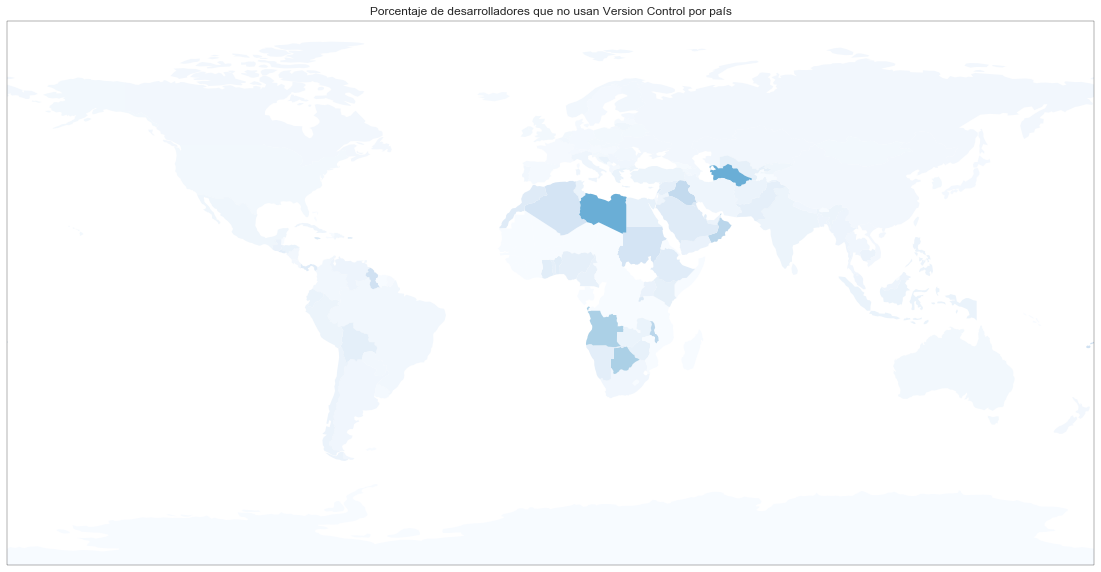

In [44]:
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
plt.figure(figsize=(20,10))

ax = plt.axes(projection=ccrs.PlateCarree())
for country in shpreader.Reader(countries_shp).records():
    try:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                facecolor=df_country_vc.loc[country.attributes['NAME_LONG'], "percentage"],
                label=country.attributes['NAME_LONG'])
    except KeyError:
        continue

plt.title("Porcentaje de desarrolladores que no usan Version Control por país")
plt.show()

Este fenómeno también se puede observar usando las razas de los usuarios de StackOverflow, donde los resultados coinciden con los datos de países

In [37]:
vc_race = ['Visual_Source_Safe_VC',
'Git_VC',
'Subversion_VC',
'I_don\'t_use_version_control_VC',
'I_use_some_other_system_VC',
'Copying_and_pasting_files_to_network_shares_VC',
'Team_Foundation_Version_Control_VC',
'Mercurial_VC',
'Rational_ClearCase_VC',
'Zip_file_back_ups_VC',
'Team_Foundation_Server_VC',
'I_prefer_not_to_say_Race',
'East_Asian_Race',
'Hispanic_or_Latino/Latina_Race',
'Native_American,_Pacific_Islander,_or_Indigenous_Australian_Race',
'Middle_Eastern_Race',
'Black_or_of_African_descent_Race',
'White_or_of_European_descent_Race',
'I_don’t_know_Race',
'South_Asian_Race',]
df_vc_race = df.loc[:,vc_race]

In [38]:
vc = ['Visual_Source_Safe_VC',
'Git_VC',
'Subversion_VC',
'I_don\'t_use_version_control_VC',
'I_use_some_other_system_VC',
'Copying_and_pasting_files_to_network_shares_VC',
'Team_Foundation_Version_Control_VC',
'Mercurial_VC',
'Rational_ClearCase_VC',
'Zip_file_back_ups_VC',
'Team_Foundation_Server_VC',]
race = ['I_prefer_not_to_say_Race',
'East_Asian_Race',
'Hispanic_or_Latino/Latina_Race',
'Native_American,_Pacific_Islander,_or_Indigenous_Australian_Race',
'Middle_Eastern_Race',
'Black_or_of_African_descent_Race',
'White_or_of_European_descent_Race',
'I_don’t_know_Race',
'South_Asian_Race',]
vc_race_vis = pd.DataFrame(0, columns=race, index=vc)

In [39]:
for r in vc:
    vc_race_vis.loc[r] = df_vc_race.groupby(r).sum().loc[[1], race].values.astype(int)
scaler = MinMaxScaler()
vc_race_vis_without_git = vc_race_vis.drop("Git_VC")
vc_race_vis[vc_race_vis.columns] = scaler.fit_transform(vc_race_vis[vc_race_vis.columns] )
vc_race_vis_without_git[vc_race_vis.columns] = scaler.fit_transform(vc_race_vis_without_git[vc_race_vis_without_git.columns] )

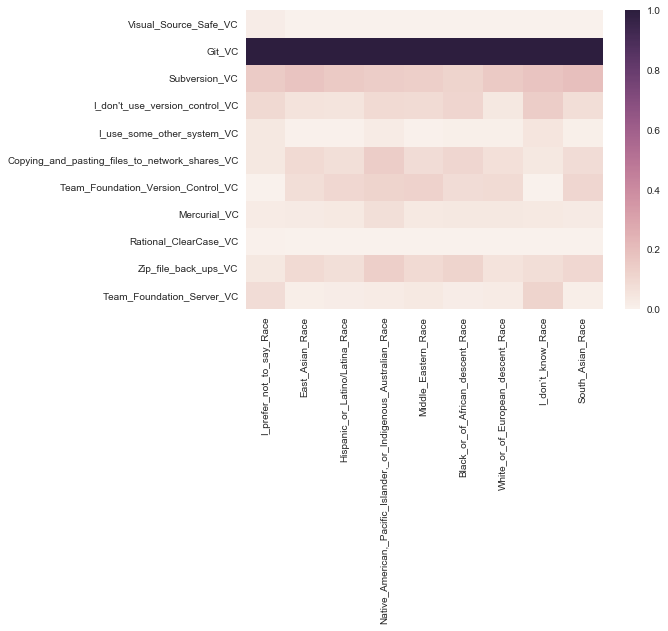

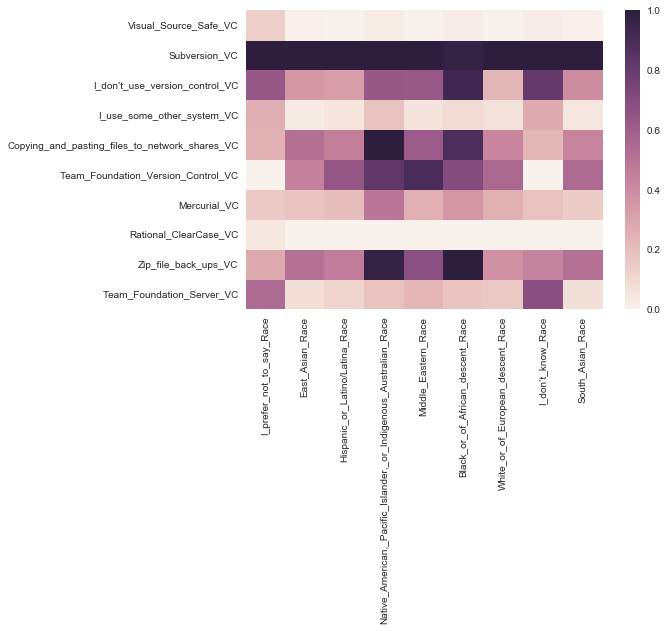

In [40]:
sns.heatmap(vc_race_vis)
plt.show()
sns.heatmap(vc_race_vis_without_git)
plt.show()

## Preferencia de IDE por país
Por cada país se muestra el IDE más popular

In [45]:
ide_country = ['Country',
               'Notepad++_IDE',
                'Android_Studio_IDE',
                'Sublime_Text_IDE',
                'Zend_IDE',
                'PHPStorm_IDE',
                'Light_Table_IDE',
                'Coda_IDE',
                'Visual_Studio_IDE',
                'Atom_IDE',
                'Visual_Studio_Code_IDE',
                'Xcode_IDE',
                'NetBeans_IDE',
                'IntelliJ_IDE',
                'Vim_IDE',
                'RStudio_IDE',
                'TextMate_IDE',
                'Komodo_IDE',
                'Eclipse_IDE',
                'PyCharm_IDE',
                'RubyMine_IDE',
                'IPython_/_Jupyter_IDE',
                'Emacs_IDE',]
df_country_ide = df.loc[:, ide_country]
df_country_ide = df_country_ide.groupby("Country").sum()
df_country_ide['Max'] = df_country_ide.idxmax(axis=1)
df_country_ide = df_country_ide.loc[:,["Max"]]

In [46]:
N = 14 # Number of labels

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

colors = []
for i in range(14):
    colors.append(cmap(i/14))

In [47]:
ide_color = dict(zip(df_country_ide['Max'].unique().tolist(), colors))
df_country_ide["Color"] = df_country_ide["Max"].map(ide_color)

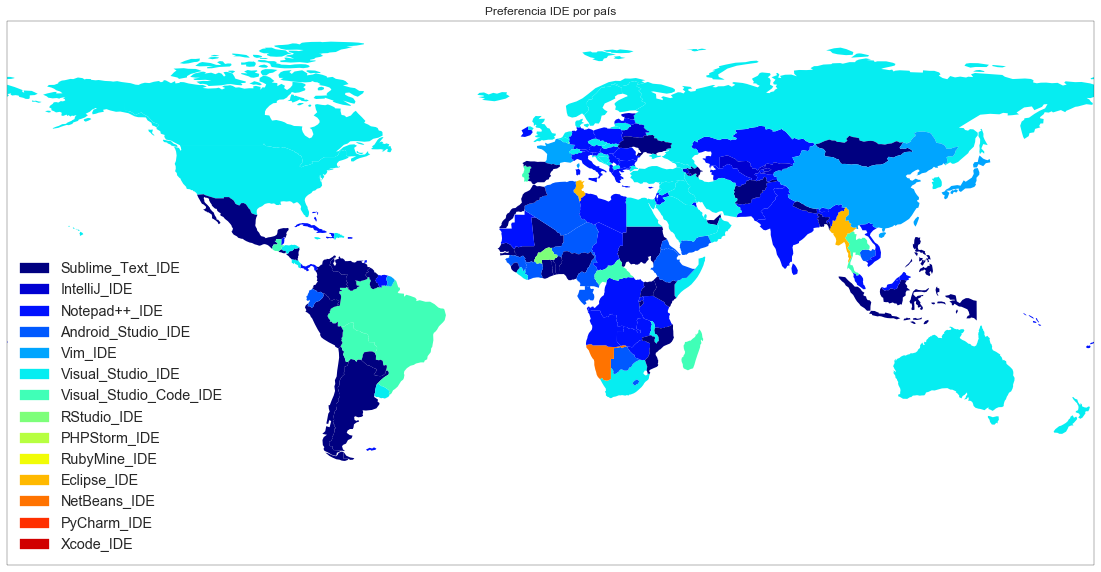

In [48]:
df_country_ide_col = df_country_ide.loc[:, ["Color"]]

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)
plt.figure(figsize=(20,10))

ax = plt.axes(projection=ccrs.PlateCarree())
for country in shpreader.Reader(countries_shp).records():
    try:
        if country.attributes['NAME_LONG'] != "Antarctica":
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                    facecolor=df_country_ide_col.loc[country.attributes['NAME_LONG'], "Color"],
                    label=country.attributes['NAME_LONG'])
    except KeyError:
        continue
        
patchList = []
for key in ide_color:
        data_key = mpatches.Patch(color=ide_color[key], label=key)
        patchList.append(data_key)

legend = plt.legend(handles=patchList, loc=3, fontsize='large')
plt.title("Preferencia IDE por país")
plt.show()

In [57]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Lenguajes trabajados por tipo de desarrolladores
Se crea el heatmap para los lenguajes trabajados por los diferentes tipos de desarrolladores

In [58]:
devtypes = set()
for x in df2018['DevType']:
    if isinstance(x, str):
        devtypes.update(x.split(";"))

dt = df.iloc[:,22:52]
dt

devtypes = dt.columns.unique()

langs = df.iloc[:,53:95]
languages = ['JavaScript', 'HTML', 'SQL', 'Java', 'C', 'PHP', 'Python', 'Objective-C', 'C++', 'Ruby']

qty = list()
for d_type in devtypes:
    info = list()
    
    for language in languages:
        d = df[df[d_type]==True]
        d = d[d[language+"_Worked"]==True]
        info.append(d[language+"_Worked"].count())
    suma = np.sum(info)
    info = [x/suma for x in info]
    qty.append(info)

qty = np.array(qty)


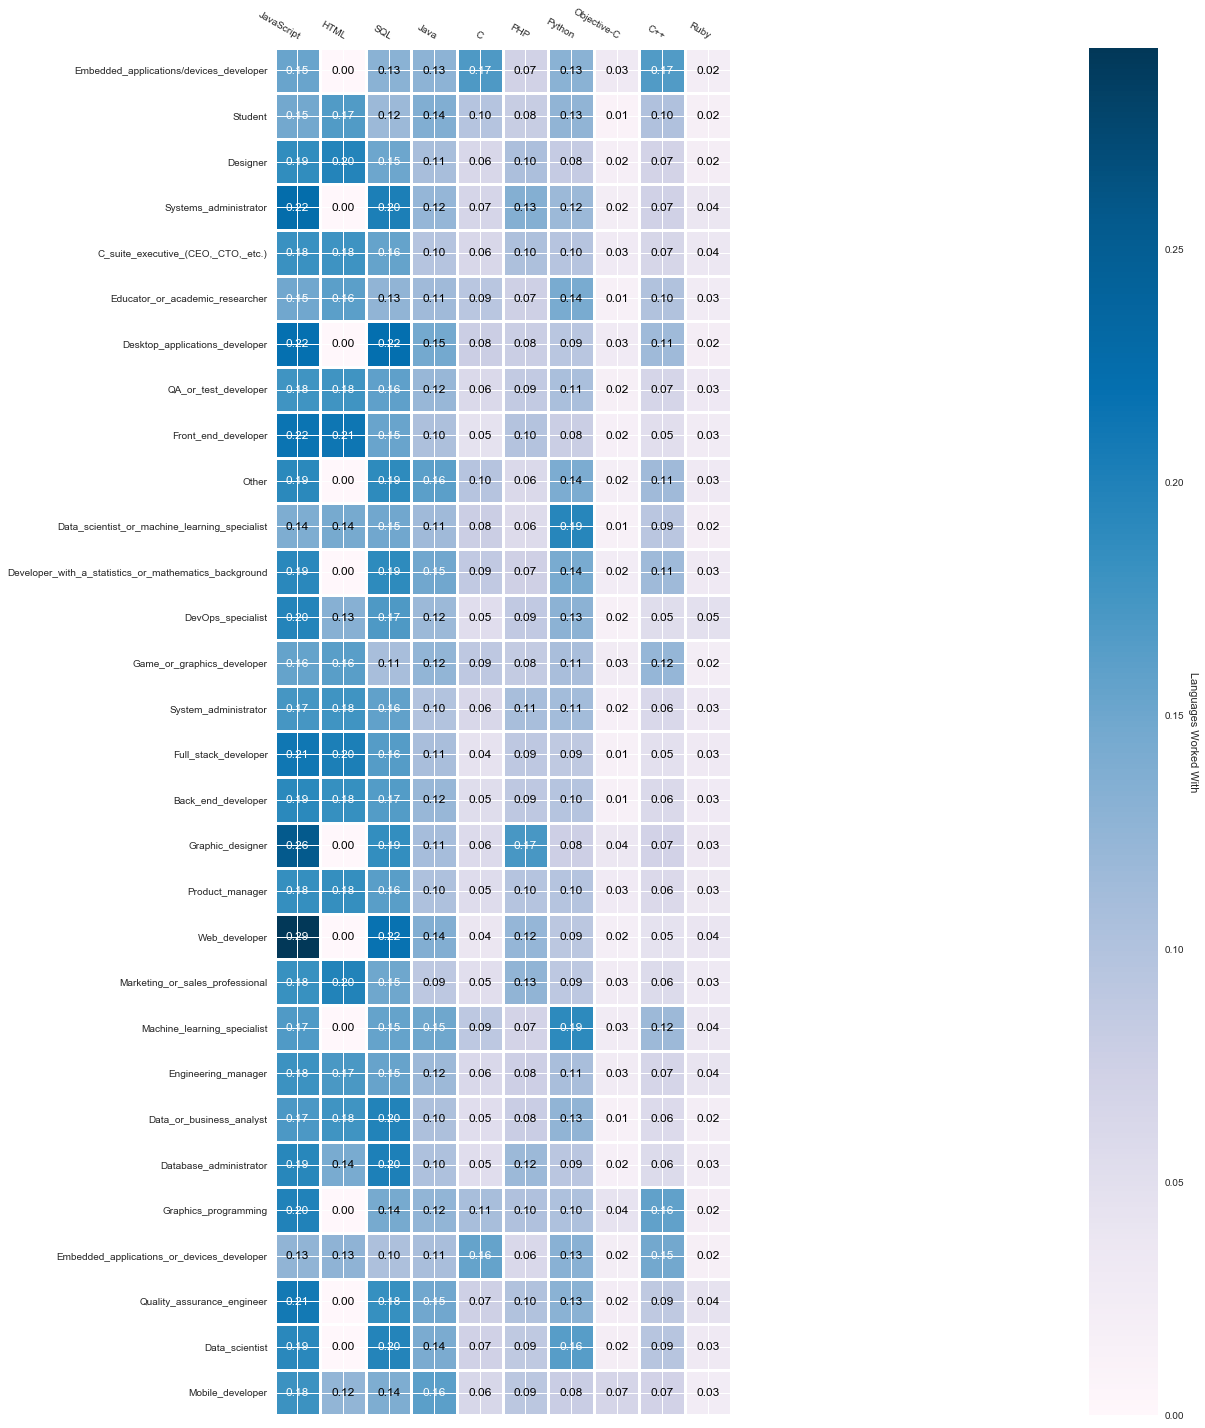

In [59]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(100)

im, cbar = heatmap(qty, devtypes, languages, ax=ax,
                   cmap="PuBu", cbarlabel="Languages Worked With")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()

## Lenguajes deseados por tipo de desarrolladores
Se crea el heatmap para los lenguajes deseados por los diferentes tipos de desarrolladores

In [64]:
d_langs = df.iloc[:,95:137]
d_languages = ['JavaScript', 'HTML', 'SQL', 'Java', 'C', 'PHP', 'Python', 'Objective-C', 'C++', 'Ruby']

qty2 = list()
for d_type in devtypes:
    info = list()
    
    for language in d_languages:
        d = df[df[d_type]==True]
        d = d[d[language+"_Desire"]==True]
        info.append(d[language+"_Desire"].count())
    suma = np.sum(info)
    info = [x/suma for x in info]
    qty2.append(info)

qty2 = np.array(qty2)


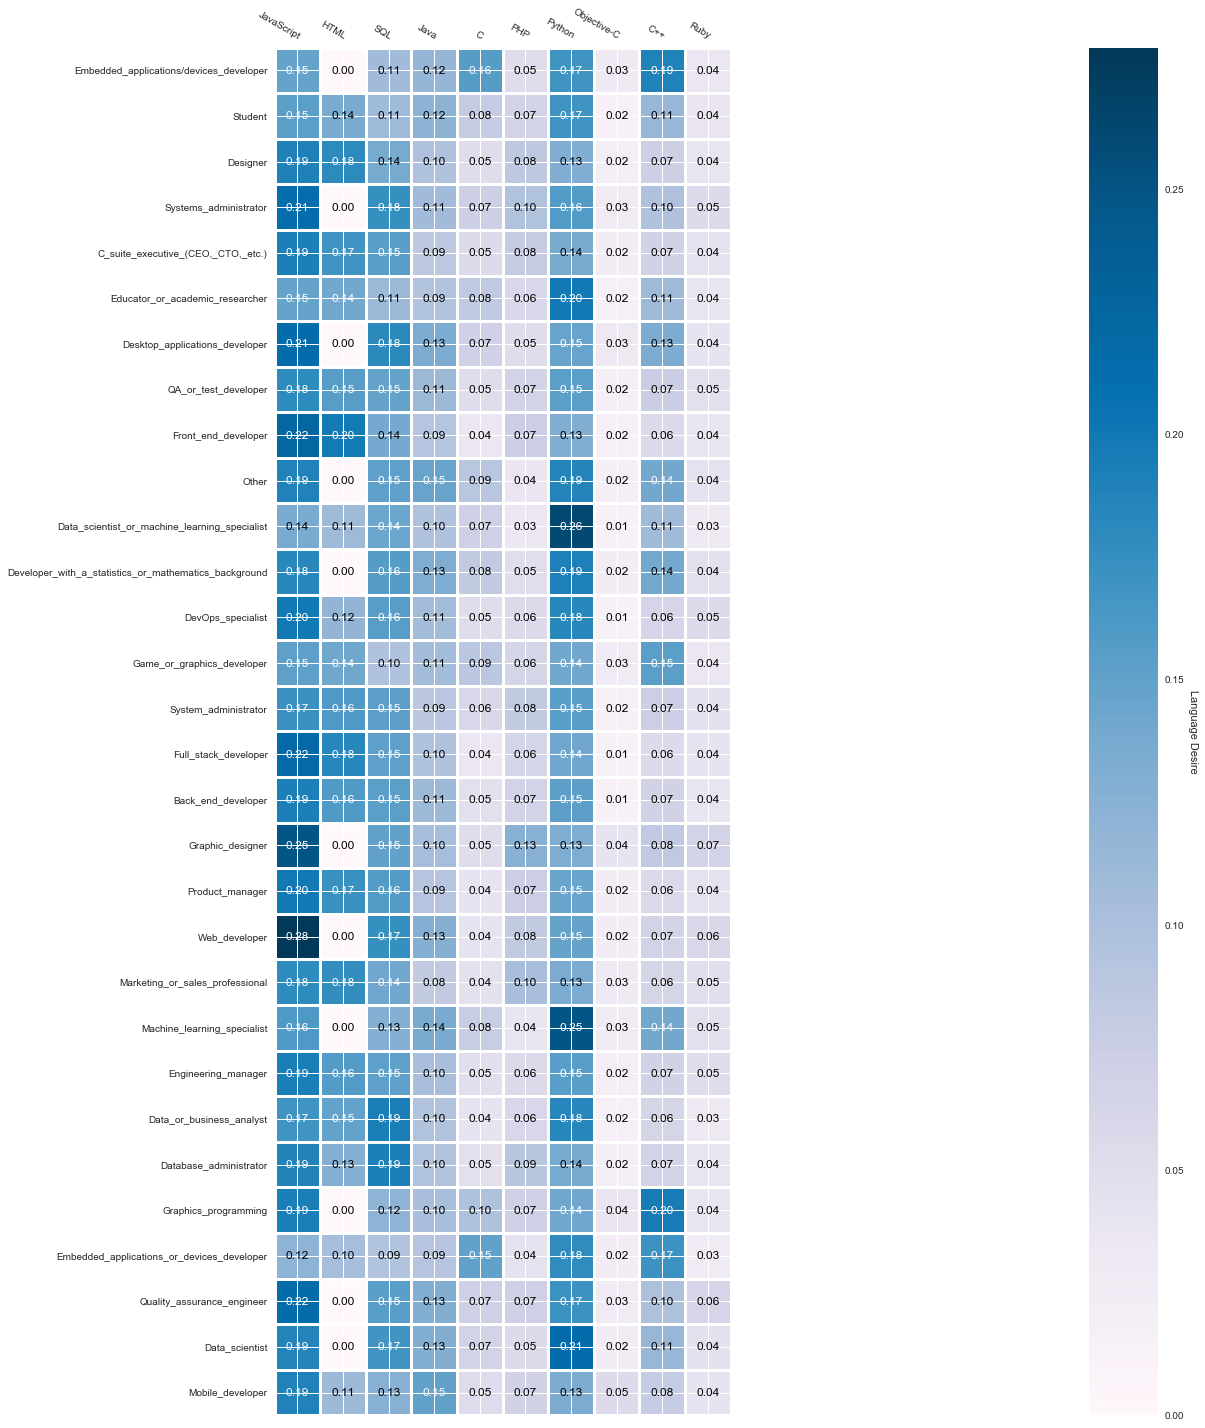

In [61]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(100)

im, cbar = heatmap(qty2, devtypes, d_languages, ax=ax,
                   cmap="PuBu", cbarlabel="Language Desire")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()

## Diferencia de tipos de desarrolladores en relación con su tiempo de trabajo
Se compara los desarrolladores que tienen más de 20 años de experiencia, con los desarrolladores nuevos, quienes tienen menos de 2 años de experiencia.

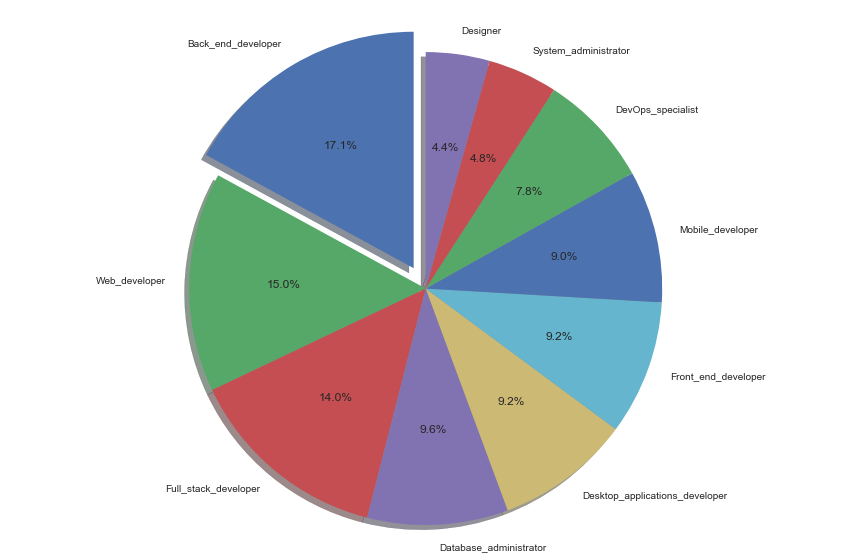

In [62]:
labels = devtypes

fracs = []


di = dict()

for t in labels:
    d = df[df['YearsCoding']=='20 or more years']
    d = d[d[t]==True]
    c = d[t].count()
    fracs.append(c)
    di[t] = c

labels = sorted(labels, key=lambda x:di[x], reverse=True)
fracs = [di[x] for x in labels]

labels = labels[:10]
fracs = fracs[:10]
explode=[0 for _ in labels]
explode[0] = 0.1

fig1, ax1 = plt.subplots()
fig1.set_figheight(10)
fig1.set_figwidth(15)
ax1.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

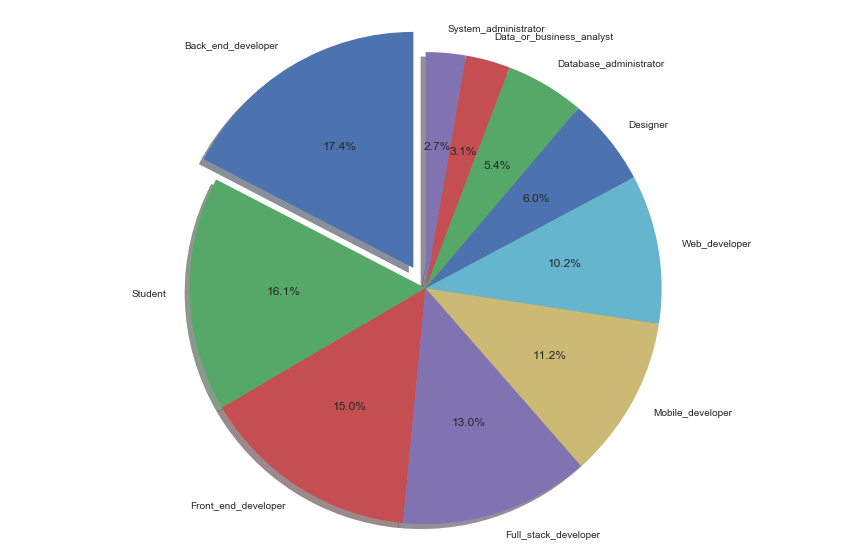

In [63]:
labels = devtypes

fracs = []


di = dict()

for t in labels:
    d = df[df['YearsCoding']=='0-2 years']
    d = d[d[t]==True]
    c = d[t].count()
    fracs.append(c)
    di[t] = c

labels = sorted(labels, key=lambda x:di[x], reverse=True)
fracs = [di[x] for x in labels]

labels = labels[:10]
fracs = fracs[:10]
explode=[0 for _ in labels]
explode[0] = 0.1

fig1, ax1 = plt.subplots()
fig1.set_figheight(10)
fig1.set_figwidth(15)
ax1.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()